In [ ]:
from sage.all import sigma, nth_prime
import pickle

def nieburTau(n):
    def step1(n, k):
        return 35*k^4 - 52*k^3*n + 18*k^2*n^2
    def step2(n, k):
        return sigma(k) * sigma(n - k)
    def step3(n):
        ans = 0
        for k in range(1, n):
            ans += step1(n, k) * step2(n, k)
        return 24*ans
    return n^4 * sigma(n) - step3(n)

def primeTau(n):
    return nieburTau(nth_prime(n))   # ✅ works in Sage 10.6

prime_tau_lst = [(0,1)]
for k in range(1, 1001):
    prime_tau_lst.append([k, primeTau(k)])
    print(k)

with open('/Users/barrybrent/data/run27aug25no2.txt', 'wb') as wfile:
    pickle.dump(prime_tau_lst, wfile) #output snipped

import pickle
with open('/Users/barrybrent/data/run27aug25no2.txt', 'rb') as rfile:
    h_list = pickle.load(rfile)
def h(n):
    return h_list[n][1]
j0=1
j_lst=[(0,j0)]
for n in [1..1000]:
    sm=0
    for r in [1..n-1]:
        sm=sm+j_lst[r][1]*h(n-r)
    jn=n*h(n)-sm
    j_lst+=[(n,jn)]
    print(n)

with open('/Users/barrybrent/data/run1sept25no1.txt', 'wb') as wfile:
    pickle.dump(j_lst, wfile) #output snipped

In [3]:
import pickle
with open('/Users/barrybrent/data/run1sept25no1.txt', 'rb') as rfile:
    j_list = pickle.load(rfile)
print(j_list[:5])

[(0, 1), (1, -24), (2, -72), (3, 18810), (4, 518528)]


STARTING P-MATRIX ANALYSIS
Checking available optimization methods...
✓ Integer matrices with 'generic' algorithm - this will provide speedup
✗ Hessenberg form failed: too many values to unpack (expected 2)

Performance expectations without LinBox:
  Matrices 1-5:   Fast (seconds)
  Matrices 6-10:  Moderate (tens of seconds)
  Matrices 11-15: Slow (minutes)
  Matrices 16+:   Very slow (many minutes to hours)
Recommendation: Start with MAX_MATRICES = 15

Input file: /Users/barrybrent/data/run1sept25no1.txt
Maximum matrices: 6
Output directory: /Users/barrybrent/data/
P-MATRIX ANALYSIS TOOL
Input file: /Users/barrybrent/data/run1sept25no1.txt
Precision: 100 decimal places
Note: All computations use exact rational arithmetic
✓ Loaded 1001 values from pickled file
Available values: 1001
Will create matrices up to size: 6x6
Output directory: /Users/barrybrent/data/run1sept25no1_pmatrix_20250908_153125

Processing P-matrix of size 1x1...
P-matrix for n=1:
  (-24)

    Computing characteristi

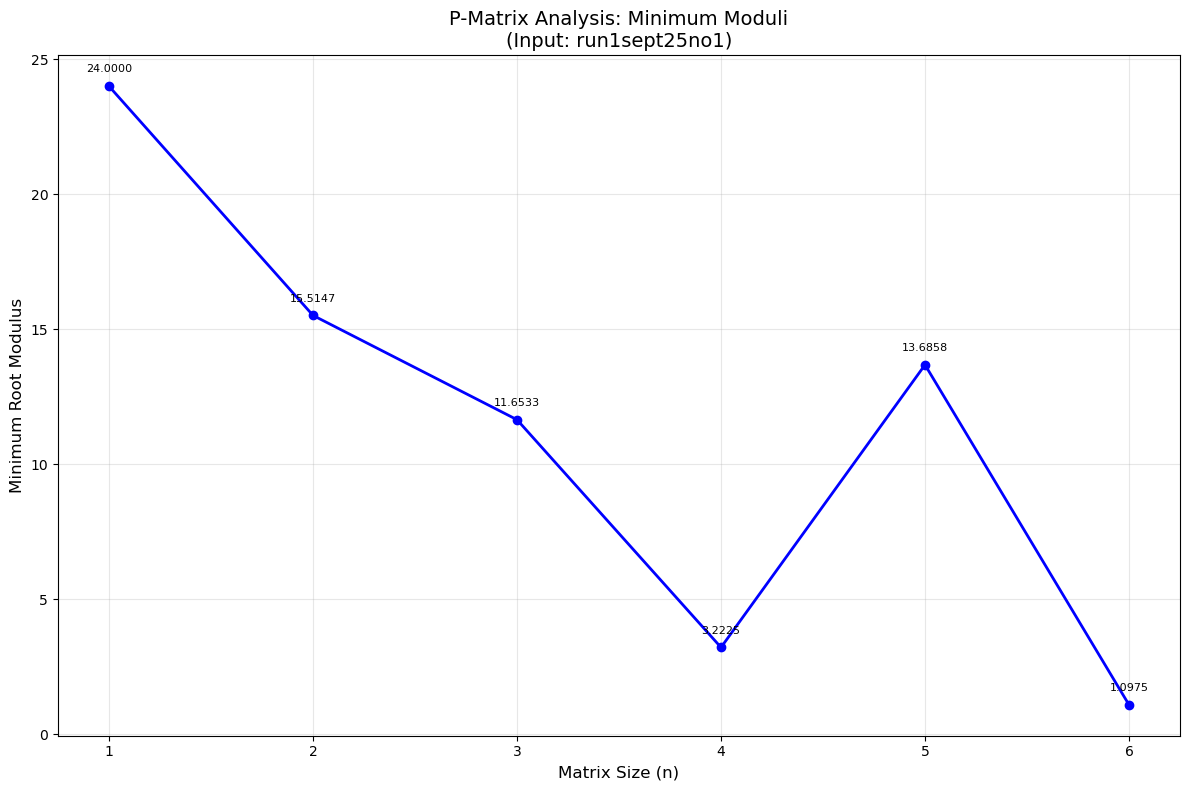


✓ ANALYSIS COMPLETE!
✓ Processed 6 matrices successfully
✓ Results saved to: /Users/barrybrent/data/run1sept25no1_pmatrix_20250908_153125
✓ All computations used exact rational arithmetic

✓ SUCCESS: Analysis completed with 6 matrices
✓ Output directory: /Users/barrybrent/data/run1sept25no1_pmatrix_20250908_153125


In [7]:
# P-matrix analysis, corrected construction per PNG and user's explicit indexing convention
import matplotlib.pyplot as plt
from sage.all import *
import os
import pickle
from datetime import datetime

VALUES_FILE = '/Users/barrybrent/data/run1sept25no1.txt'
MAX_MATRICES = 6
OUTPUT_DIR = '/Users/barrybrent/data/'

def load_values_from_file(filename):
    """Load j_list: j_list[1]=p_1, j_list[n]=p_n."""
    j_list = []
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        # If data is list of tuples: (i, val), extract val
        for entry in data:
            if isinstance(entry, (tuple, list)) and len(entry) == 2:
                j_list.append(QQ(entry[1]))
            else:
                j_list.append(QQ(entry))
        print(f"✓ Loaded {len(j_list)} values from pickled file")
        return j_list
    except Exception as e:
        print(f"Could not load as pickle: {e}")
    try:
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith('#'):
                    parts = [s for s in line.replace(',', ' ').split()]
                    for part in parts:
                        part = part.strip()
                        if part:
                            try:
                                j_list.append(QQ(part))
                            except Exception as ex:
                                print(f"Skipping value {part}: {ex}")
        print(f"✓ Loaded {len(j_list)} values from text file")
        return j_list
    except Exception as e:
        print(f"Error loading file: {e}")
        return []

def construct_p_matrix(n, j_list):
    """Construct matrix in form shown in PNG:
       - First column p_i = j_list[i] (i from 1 to n)
       - Diagonal p_1 = j_list[1]
       - Strictly lower triangle: p_{i-j+1} = j_list[i-j+1] if i>j
       - First superdiagonal: -j if j = i+1
       - Zeros elsewhere
       NOTE: Python indices: i,j both run from 0 to n-1, p_i from j_list[1] (not j_list[0])
    """
    if len(j_list) <= n:
        raise ValueError(f"Need at least n+1 j_list values; got {len(j_list)}")
    M = matrix(QQ, n, n)
    for i in range(n):
        for j in range(n):
            if j == 0:
                M[i, j] = j_list[i+1]         # First column: p_i (i+1)
            elif i == j:
                M[i, j] = j_list[1]           # Main diagonal: p_1
            elif j < i:
                M[i, j] = j_list[i-j+1]       # Lower diagonal: p_{i-j+1}
            elif j == i + 1:
                M[i, j] = - (j)               # Superdiagonal: -j
            else:
                M[i, j] = 0                   # Upper triangle and beyond superdiagonal is zero
    return M

# --- The rest of the code remains unchanged: characteristic poly, roots, output, plotting ---

def check_available_optimizations():
    print("Checking available optimization methods...")
    test_matrix = matrix(ZZ, 3, 3, [1, 2, 3, 4, 5, 6, 7, 8, 9])
    try:
        poly = test_matrix.characteristic_polynomial(algorithm='generic')
        print("✓ Integer matrices with 'generic' algorithm - this will provide speedup")
    except Exception as e:
        print(f"✗ Integer 'generic' algorithm failed: {e}")
    try:
        test_rational = matrix(QQ, 3, 3, [1, 1/2, 1/3, 1/4, 1/5, 1/6, 1/7, 1/8, 1/9])
        H, P = test_rational.hessenberg_form()
        print("✓ Hessenberg form transformation available")
    except Exception as e:
        print(f"✗ Hessenberg form failed: {e}")
    print("\nPerformance expectations without LinBox:")
    print("  Matrices 1-5:   Fast (seconds)")
    print("  Matrices 6-10:  Moderate (tens of seconds)")
    print("  Matrices 11-15: Slow (minutes)")
    print("  Matrices 16+:   Very slow (many minutes to hours)")
    print("Recommendation: Start with MAX_MATRICES = 15")
    return True

def compute_characteristic_polynomial_exact(matrix):
    import time
    start_time = time.time()
    try:
        n = matrix.nrows()
        print(f"    Computing characteristic polynomial for {n}x{n} matrix...")
        if n <= 3:
            char_poly = matrix.characteristic_polynomial()
            elapsed = time.time() - start_time
            print(f"    ✓ Standard method: {elapsed:.2f}s")
            return char_poly
        try:
            denom = lcm([matrix[i,j].denominator() for i in range(n) for j in range(n)])
            int_matrix = (matrix * denom).change_ring(ZZ)
            char_poly_scaled = int_matrix.characteristic_polynomial(algorithm='generic')
            R = PolynomialRing(QQ, 'x')
            x = R.gen()
            coeffs = char_poly_scaled.coefficients(sparse=False)
            char_poly = sum(QQ(coeffs[i]) / (denom**(n-i)) * x**i for i in range(len(coeffs)))
            elapsed = time.time() - start_time
            print(f"    ✓ Exact integer optimization: {elapsed:.2f}s")
            return char_poly
        except Exception as int_error:
            print(f"    Integer optimization failed: {int_error}")
        if n > 8:
            try:
                print(f"    Trying Hessenberg transformation...")
                H, P = matrix.hessenberg_form()
                char_poly = H.characteristic_polynomial()
                elapsed = time.time() - start_time
                print(f"    ✓ Hessenberg method: {elapsed:.2f}s")
                return char_poly
            except Exception as hess_error:
                print(f"    Hessenberg failed: {hess_error}")
        print(f"    Using standard exact method...")
        char_poly = matrix.characteristic_polynomial()
        elapsed = time.time() - start_time
        print(f"    ✓ Standard method completed: {elapsed:.2f}s")
        return char_poly
    except Exception as e:
        elapsed = time.time() - start_time
        print(f"    ❌ All methods failed after {elapsed:.2f}s: {e}")
        return None

def find_minimum_modulus_root_precise(polynomial, precision=100):
    try:
        print(f"    Finding minimum modulus root with {precision}-digit precision...")
        CC_prec = ComplexField(precision)
        roots = polynomial.roots(ring=CC_prec, multiplicities=False)
        if not roots:
            return None, None, None
        root_moduli = [(root, abs(root)) for root in roots]
        min_root, min_modulus = min(root_moduli, key=lambda x: x[1])
        CC_storage = ComplexField(precision + 50)
        high_roots = polynomial.roots(ring=CC_storage, multiplicities=False)
        high_moduli = [(root, abs(root)) for root in high_roots]
        storage_root, storage_modulus = min(high_moduli, key=lambda x: x[1])
        print(f"    ✓ Found minimum modulus: {float(storage_modulus):.8f}")
        return min_root, min_modulus, storage_root
    except Exception as e:
        print(f"    Error finding roots: {e}")
        return None, None, None

def setup_output_directory(base_dir, input_file):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    input_base = os.path.splitext(os.path.basename(input_file))[0]
    output_dir = os.path.join(base_dir, f"{input_base}_pmatrix_{timestamp}")
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

def save_matrix_data(output_dir, n, matrix, char_poly, min_root, min_modulus, storage_root):
    matrix_file = os.path.join(output_dir, f"matrix_{n}x{n}.txt")
    with open(matrix_file, 'w') as f:
        f.write(f"P-Matrix {n}x{n}:\n")
        for i in range(n):
            row = [str(matrix[i,j]) for j in range(n)]
            f.write("[" + ", ".join(row) + "]\n")
    poly_file = os.path.join(output_dir, f"polynomial_{n}x{n}.txt")
    with open(poly_file, 'w') as f:
        f.write(f"Characteristic Polynomial for {n}x{n} P-matrix:\n")
        f.write(f"Degree: {char_poly.degree()}\n")
        f.write(f"Polynomial (exact QQ format): {char_poly}\n")
        f.write(f"Ring: {char_poly.parent()}\n")
        coeffs = char_poly.coefficients(sparse=False)
        f.write(f"Coefficients (QQ): {[QQ(c) for c in coeffs]}\n")
    root_file = os.path.join(output_dir, f"root_data_{n}x{n}.txt")
    with open(root_file, 'w') as f:
        f.write(f"Root Data for {n}x{n} P-matrix:\n")
        f.write(f"Minimum modulus root: {min_root}\n")
        f.write(f"Minimum modulus: {min_modulus}\n")
        f.write(f"High precision root (100+ digits): {storage_root}\n")
        f.write(f"High precision modulus (100+ digits): {abs(storage_root)}\n")
    tuple_file = os.path.join(output_dir, f"tuple_{n}x{n}.txt")
    with open(tuple_file, 'w') as f:
        f.write(f"({n}, '{char_poly}', '{storage_root}', '{abs(storage_root)}', {float(abs(storage_root)):.12f})\n")

def save_consolidated_results(output_dir, all_tuples, n_values, moduli_values, input_file, values):
    summary_file = os.path.join(output_dir, "SUMMARY_human_readable.txt")
    with open(summary_file, 'w') as f:
        f.write("P-MATRIX ANALYSIS SUMMARY\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Input file: {input_file}\n")
        f.write(f"Matrix type: P-matrices\n")
        f.write(f"Matrices processed: {len(n_values)}\n")
        f.write(f"Parameter values: {values[:min(10, len(values))]}")
        if len(values) > 10:
            f.write("...")
        f.write("\n\n")
        f.write("MINIMUM MODULI SUMMARY:\n")
        f.write("-" * 40 + "\n")
        f.write("Matrix Size\tMinimum Modulus (12 decimal places)\n")
        f.write("-" * 40 + "\n")
        for n, modulus in zip(n_values, moduli_values):
            f.write(f"{n}x{n}\t\t{modulus:.12f}\n")
    tuples_file = os.path.join(output_dir, "ALL_TUPLES_raw_data.txt")
    with open(tuples_file, 'w') as f:
        for tuple_data in all_tuples:
            f.write(str(tuple_data) + "\n")
    pickle_file = os.path.join(output_dir, "results_data.pkl")
    with open(pickle_file, 'wb') as f:
        pickle.dump({
            'tuples': all_tuples,
            'n_values': n_values,
            'moduli_values': moduli_values,
            'matrix_type': 'P',
            'input_file': input_file,
            'parameter_values': values
        }, f)

def create_plot_with_error_handling(output_dir, n_values, moduli_values, input_file):
    try:
        plt.figure(figsize=(12, 8))
        plt.plot(n_values, moduli_values, 'bo-', linewidth=2, markersize=6)
        plt.xlabel('Matrix Size (n)', fontsize=12)
        plt.ylabel('Minimum Root Modulus', fontsize=12)
        file_base = os.path.splitext(os.path.basename(input_file))[0]
        plt.title(f'P-Matrix Analysis: Minimum Moduli\n(Input: {file_base})', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.xticks(n_values)
        for i, (x, y) in enumerate(zip(n_values, moduli_values)):
            plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8)
        plt.tight_layout()
        plot_file = os.path.join(output_dir, "minimum_moduli_plot.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"✓ Plot saved to: {plot_file}")
        try:
            plt.show()
        except:
            print("  (Plot display not available, but saved to file)")
    except Exception as e:
        print(f"Warning: Could not create plot: {e}")
        print("  Continuing with analysis...")

def analyze_p_matrices(values_file, max_n=None, precision=100, output_base_dir=None):
    print("P-MATRIX ANALYSIS TOOL")
    print("=" * 60)
    print(f"Input file: {values_file}")
    print(f"Precision: {precision} decimal places")
    print("Note: All computations use exact rational arithmetic")
    j_list = load_values_from_file(values_file)
    if not j_list:
        print("❌ No values loaded. Exiting.")
        return []
    # j_list[0] = placeholder; j_list[1] = p_1, ..., j_list[n] = p_n
    if max_n is None:
        max_n = len(j_list)-1
    else:
        max_n = min(max_n, len(j_list)-1)
    print(f"Available values: {len(j_list)}")
    print(f"Will create matrices up to size: {max_n}x{max_n}")
    if output_base_dir is None:
        output_base_dir = os.path.dirname(values_file)
    output_dir = setup_output_directory(output_base_dir, values_file)
    print(f"Output directory: {output_dir}")
    print("=" * 60)
    results = []
    n_values = []
    moduli_values = []
    all_tuples = []
    for n in range(1, max_n + 1):
        print(f"\nProcessing P-matrix of size {n}x{n}...")
        try:
            matrix = construct_p_matrix(n, j_list)
            print(f"P-matrix for n={n}:")
            for row in matrix.rows():
                print("  " + str(row))
            print("")
            char_poly = compute_characteristic_polynomial_exact(matrix)
            if char_poly is None:
                print(f"  ❌ Failed to compute polynomial")
                continue
            min_root, min_modulus, storage_root = find_minimum_modulus_root_precise(char_poly, precision)
            if min_root is None:
                print(f"  ❌ Failed to find roots")
                continue
            save_matrix_data(output_dir, n, matrix, char_poly, min_root, min_modulus, storage_root)
            tuple_data = (n, str(char_poly), str(storage_root), str(abs(storage_root)), float(abs(storage_root)))
            results.append((n, char_poly, min_root, min_modulus))
            all_tuples.append(tuple_data)
            n_values.append(n)
            moduli_values.append(float(abs(storage_root)))
            print(f"  ✓ Completed. Min modulus: {float(abs(storage_root)):.8f}")
        except Exception as e:
            print(f"  ❌ Error processing matrix {n}x{n}: {e}")
            continue
    save_consolidated_results(output_dir, all_tuples, n_values, moduli_values, values_file, j_list)
    if n_values and moduli_values:
        create_plot_with_error_handling(output_dir, n_values, moduli_values, values_file)
    print(f"\n" + "=" * 60)
    print("✓ ANALYSIS COMPLETE!")
    print(f"✓ Processed {len(results)} matrices successfully")
    print(f"✓ Results saved to: {output_dir}")
    print("✓ All computations used exact rational arithmetic")
    print("=" * 60)
    return results, output_dir

if __name__ == "__main__":
    print("STARTING P-MATRIX ANALYSIS")
    print("=" * 60)
    optimizations_available = check_available_optimizations()
    print(f"\nInput file: {VALUES_FILE}")
    if MAX_MATRICES is not None:
        print(f"Maximum matrices: {MAX_MATRICES}")
    else:
        print("Maximum matrices: All available")
    print(f"Output directory: {OUTPUT_DIR}")
    print("=" * 60)
    try:
        results, output_directory = analyze_p_matrices(VALUES_FILE, max_n=MAX_MATRICES, output_base_dir=OUTPUT_DIR)
        if results:
            print(f"\n✓ SUCCESS: Analysis completed with {len(results)} matrices")
            print(f"✓ Output directory: {output_directory}")
        else:
            print("\n❌ No matrices were successfully processed")
    except Exception as e:
        print(f"\n❌ Analysis failed: {e}")
        import traceback
        traceback.print_exc()


STARTING P-MATRIX ANALYSIS
Checking available optimization methods...
✓ Integer matrices with 'generic' algorithm - this will provide speedup
✗ Hessenberg form failed: too many values to unpack (expected 2)

Performance expectations without LinBox:
  Matrices 1-5:   Fast (seconds)
  Matrices 6-10:  Moderate (tens of seconds)
  Matrices 11-15: Slow (minutes)
  Matrices 16+:   Very slow (many minutes to hours)
Recommendation: Start with MAX_MATRICES = 15

Input file: /Users/barrybrent/data/run1sept25no1.txt
Maximum matrices: 10
Output directory: /Users/barrybrent/data/
P-MATRIX ANALYSIS TOOL
Input file: /Users/barrybrent/data/run1sept25no1.txt
Precision: 100 decimal places
Note: All computations use exact rational arithmetic
✓ Loaded 1001 values from pickled file
Available values: 1001
Will create matrices up to size: 10x10
Output directory: /Users/barrybrent/data/run1sept25no1_pmatrix_20250908_153847

Processing P-matrix of size 1x1...
P-matrix for n=1:
  (-24)

    Computing characteri

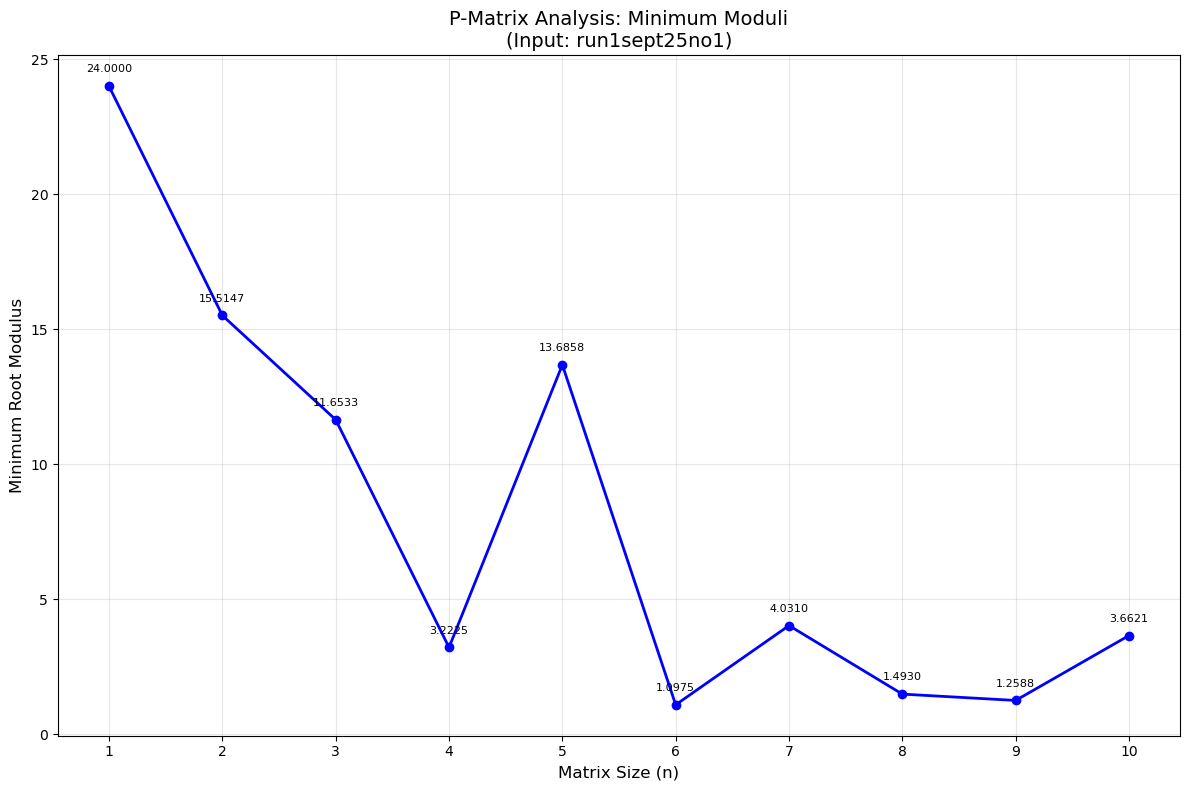


✓ ANALYSIS COMPLETE!
✓ Processed 10 matrices successfully
✓ Results saved to: /Users/barrybrent/data/run1sept25no1_pmatrix_20250908_153847
✓ All computations used exact rational arithmetic

✓ SUCCESS: Analysis completed with 10 matrices
✓ Output directory: /Users/barrybrent/data/run1sept25no1_pmatrix_20250908_153847


In [8]:
# P-matrix analysis, corrected construction per PNG and user's explicit indexing convention
import matplotlib.pyplot as plt
from sage.all import *
import os
import pickle
from datetime import datetime

VALUES_FILE = '/Users/barrybrent/data/run1sept25no1.txt'
MAX_MATRICES = 10
OUTPUT_DIR = '/Users/barrybrent/data/'

def load_values_from_file(filename):
    """Load j_list: j_list[1]=p_1, j_list[n]=p_n."""
    j_list = []
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        # If data is list of tuples: (i, val), extract val
        for entry in data:
            if isinstance(entry, (tuple, list)) and len(entry) == 2:
                j_list.append(QQ(entry[1]))
            else:
                j_list.append(QQ(entry))
        print(f"✓ Loaded {len(j_list)} values from pickled file")
        return j_list
    except Exception as e:
        print(f"Could not load as pickle: {e}")
    try:
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith('#'):
                    parts = [s for s in line.replace(',', ' ').split()]
                    for part in parts:
                        part = part.strip()
                        if part:
                            try:
                                j_list.append(QQ(part))
                            except Exception as ex:
                                print(f"Skipping value {part}: {ex}")
        print(f"✓ Loaded {len(j_list)} values from text file")
        return j_list
    except Exception as e:
        print(f"Error loading file: {e}")
        return []

def construct_p_matrix(n, j_list):
    """Construct matrix in form shown in PNG:
       - First column p_i = j_list[i] (i from 1 to n)
       - Diagonal p_1 = j_list[1]
       - Strictly lower triangle: p_{i-j+1} = j_list[i-j+1] if i>j
       - First superdiagonal: -j if j = i+1
       - Zeros elsewhere
       NOTE: Python indices: i,j both run from 0 to n-1, p_i from j_list[1] (not j_list[0])
    """
    if len(j_list) <= n:
        raise ValueError(f"Need at least n+1 j_list values; got {len(j_list)}")
    M = matrix(QQ, n, n)
    for i in range(n):
        for j in range(n):
            if j == 0:
                M[i, j] = j_list[i+1]         # First column: p_i (i+1)
            elif i == j:
                M[i, j] = j_list[1]           # Main diagonal: p_1
            elif j < i:
                M[i, j] = j_list[i-j+1]       # Lower diagonal: p_{i-j+1}
            elif j == i + 1:
                M[i, j] = - (j)               # Superdiagonal: -j
            else:
                M[i, j] = 0                   # Upper triangle and beyond superdiagonal is zero
    return M

# --- The rest of the code remains unchanged: characteristic poly, roots, output, plotting ---

def check_available_optimizations():
    print("Checking available optimization methods...")
    test_matrix = matrix(ZZ, 3, 3, [1, 2, 3, 4, 5, 6, 7, 8, 9])
    try:
        poly = test_matrix.characteristic_polynomial(algorithm='generic')
        print("✓ Integer matrices with 'generic' algorithm - this will provide speedup")
    except Exception as e:
        print(f"✗ Integer 'generic' algorithm failed: {e}")
    try:
        test_rational = matrix(QQ, 3, 3, [1, 1/2, 1/3, 1/4, 1/5, 1/6, 1/7, 1/8, 1/9])
        H, P = test_rational.hessenberg_form()
        print("✓ Hessenberg form transformation available")
    except Exception as e:
        print(f"✗ Hessenberg form failed: {e}")
    print("\nPerformance expectations without LinBox:")
    print("  Matrices 1-5:   Fast (seconds)")
    print("  Matrices 6-10:  Moderate (tens of seconds)")
    print("  Matrices 11-15: Slow (minutes)")
    print("  Matrices 16+:   Very slow (many minutes to hours)")
    print("Recommendation: Start with MAX_MATRICES = 15")
    return True

def compute_characteristic_polynomial_exact(matrix):
    import time
    start_time = time.time()
    try:
        n = matrix.nrows()
        print(f"    Computing characteristic polynomial for {n}x{n} matrix...")
        if n <= 3:
            char_poly = matrix.characteristic_polynomial()
            elapsed = time.time() - start_time
            print(f"    ✓ Standard method: {elapsed:.2f}s")
            return char_poly
        try:
            denom = lcm([matrix[i,j].denominator() for i in range(n) for j in range(n)])
            int_matrix = (matrix * denom).change_ring(ZZ)
            char_poly_scaled = int_matrix.characteristic_polynomial(algorithm='generic')
            R = PolynomialRing(QQ, 'x')
            x = R.gen()
            coeffs = char_poly_scaled.coefficients(sparse=False)
            char_poly = sum(QQ(coeffs[i]) / (denom**(n-i)) * x**i for i in range(len(coeffs)))
            elapsed = time.time() - start_time
            print(f"    ✓ Exact integer optimization: {elapsed:.2f}s")
            return char_poly
        except Exception as int_error:
            print(f"    Integer optimization failed: {int_error}")
        if n > 8:
            try:
                print(f"    Trying Hessenberg transformation...")
                H, P = matrix.hessenberg_form()
                char_poly = H.characteristic_polynomial()
                elapsed = time.time() - start_time
                print(f"    ✓ Hessenberg method: {elapsed:.2f}s")
                return char_poly
            except Exception as hess_error:
                print(f"    Hessenberg failed: {hess_error}")
        print(f"    Using standard exact method...")
        char_poly = matrix.characteristic_polynomial()
        elapsed = time.time() - start_time
        print(f"    ✓ Standard method completed: {elapsed:.2f}s")
        return char_poly
    except Exception as e:
        elapsed = time.time() - start_time
        print(f"    ❌ All methods failed after {elapsed:.2f}s: {e}")
        return None

def find_minimum_modulus_root_precise(polynomial, precision=100):
    try:
        print(f"    Finding minimum modulus root with {precision}-digit precision...")
        CC_prec = ComplexField(precision)
        roots = polynomial.roots(ring=CC_prec, multiplicities=False)
        if not roots:
            return None, None, None
        root_moduli = [(root, abs(root)) for root in roots]
        min_root, min_modulus = min(root_moduli, key=lambda x: x[1])
        CC_storage = ComplexField(precision + 50)
        high_roots = polynomial.roots(ring=CC_storage, multiplicities=False)
        high_moduli = [(root, abs(root)) for root in high_roots]
        storage_root, storage_modulus = min(high_moduli, key=lambda x: x[1])
        print(f"    ✓ Found minimum modulus: {float(storage_modulus):.8f}")
        return min_root, min_modulus, storage_root
    except Exception as e:
        print(f"    Error finding roots: {e}")
        return None, None, None

def setup_output_directory(base_dir, input_file):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    input_base = os.path.splitext(os.path.basename(input_file))[0]
    output_dir = os.path.join(base_dir, f"{input_base}_pmatrix_{timestamp}")
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

def save_matrix_data(output_dir, n, matrix, char_poly, min_root, min_modulus, storage_root):
    matrix_file = os.path.join(output_dir, f"matrix_{n}x{n}.txt")
    with open(matrix_file, 'w') as f:
        f.write(f"P-Matrix {n}x{n}:\n")
        for i in range(n):
            row = [str(matrix[i,j]) for j in range(n)]
            f.write("[" + ", ".join(row) + "]\n")
    poly_file = os.path.join(output_dir, f"polynomial_{n}x{n}.txt")
    with open(poly_file, 'w') as f:
        f.write(f"Characteristic Polynomial for {n}x{n} P-matrix:\n")
        f.write(f"Degree: {char_poly.degree()}\n")
        f.write(f"Polynomial (exact QQ format): {char_poly}\n")
        f.write(f"Ring: {char_poly.parent()}\n")
        coeffs = char_poly.coefficients(sparse=False)
        f.write(f"Coefficients (QQ): {[QQ(c) for c in coeffs]}\n")
    root_file = os.path.join(output_dir, f"root_data_{n}x{n}.txt")
    with open(root_file, 'w') as f:
        f.write(f"Root Data for {n}x{n} P-matrix:\n")
        f.write(f"Minimum modulus root: {min_root}\n")
        f.write(f"Minimum modulus: {min_modulus}\n")
        f.write(f"High precision root (100+ digits): {storage_root}\n")
        f.write(f"High precision modulus (100+ digits): {abs(storage_root)}\n")
    tuple_file = os.path.join(output_dir, f"tuple_{n}x{n}.txt")
    with open(tuple_file, 'w') as f:
        f.write(f"({n}, '{char_poly}', '{storage_root}', '{abs(storage_root)}', {float(abs(storage_root)):.12f})\n")

def save_consolidated_results(output_dir, all_tuples, n_values, moduli_values, input_file, values):
    summary_file = os.path.join(output_dir, "SUMMARY_human_readable.txt")
    with open(summary_file, 'w') as f:
        f.write("P-MATRIX ANALYSIS SUMMARY\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Input file: {input_file}\n")
        f.write(f"Matrix type: P-matrices\n")
        f.write(f"Matrices processed: {len(n_values)}\n")
        f.write(f"Parameter values: {values[:min(10, len(values))]}")
        if len(values) > 10:
            f.write("...")
        f.write("\n\n")
        f.write("MINIMUM MODULI SUMMARY:\n")
        f.write("-" * 40 + "\n")
        f.write("Matrix Size\tMinimum Modulus (12 decimal places)\n")
        f.write("-" * 40 + "\n")
        for n, modulus in zip(n_values, moduli_values):
            f.write(f"{n}x{n}\t\t{modulus:.12f}\n")
    tuples_file = os.path.join(output_dir, "ALL_TUPLES_raw_data.txt")
    with open(tuples_file, 'w') as f:
        for tuple_data in all_tuples:
            f.write(str(tuple_data) + "\n")
    pickle_file = os.path.join(output_dir, "results_data.pkl")
    with open(pickle_file, 'wb') as f:
        pickle.dump({
            'tuples': all_tuples,
            'n_values': n_values,
            'moduli_values': moduli_values,
            'matrix_type': 'P',
            'input_file': input_file,
            'parameter_values': values
        }, f)

def create_plot_with_error_handling(output_dir, n_values, moduli_values, input_file):
    try:
        plt.figure(figsize=(12, 8))
        plt.plot(n_values, moduli_values, 'bo-', linewidth=2, markersize=6)
        plt.xlabel('Matrix Size (n)', fontsize=12)
        plt.ylabel('Minimum Root Modulus', fontsize=12)
        file_base = os.path.splitext(os.path.basename(input_file))[0]
        plt.title(f'P-Matrix Analysis: Minimum Moduli\n(Input: {file_base})', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.xticks(n_values)
        for i, (x, y) in enumerate(zip(n_values, moduli_values)):
            plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8)
        plt.tight_layout()
        plot_file = os.path.join(output_dir, "minimum_moduli_plot.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"✓ Plot saved to: {plot_file}")
        try:
            plt.show()
        except:
            print("  (Plot display not available, but saved to file)")
    except Exception as e:
        print(f"Warning: Could not create plot: {e}")
        print("  Continuing with analysis...")

def analyze_p_matrices(values_file, max_n=None, precision=100, output_base_dir=None):
    print("P-MATRIX ANALYSIS TOOL")
    print("=" * 60)
    print(f"Input file: {values_file}")
    print(f"Precision: {precision} decimal places")
    print("Note: All computations use exact rational arithmetic")
    j_list = load_values_from_file(values_file)
    if not j_list:
        print("❌ No values loaded. Exiting.")
        return []
    # j_list[0] = placeholder; j_list[1] = p_1, ..., j_list[n] = p_n
    if max_n is None:
        max_n = len(j_list)-1
    else:
        max_n = min(max_n, len(j_list)-1)
    print(f"Available values: {len(j_list)}")
    print(f"Will create matrices up to size: {max_n}x{max_n}")
    if output_base_dir is None:
        output_base_dir = os.path.dirname(values_file)
    output_dir = setup_output_directory(output_base_dir, values_file)
    print(f"Output directory: {output_dir}")
    print("=" * 60)
    results = []
    n_values = []
    moduli_values = []
    all_tuples = []
    for n in range(1, max_n + 1):
        print(f"\nProcessing P-matrix of size {n}x{n}...")
        try:
            matrix = construct_p_matrix(n, j_list)
            print(f"P-matrix for n={n}:")
            for row in matrix.rows():
                if n<5:
                    print("  " + str(row))
            print("")
            char_poly = compute_characteristic_polynomial_exact(matrix)
            if char_poly is None:
                print(f"  ❌ Failed to compute polynomial")
                continue
            min_root, min_modulus, storage_root = find_minimum_modulus_root_precise(char_poly, precision)
            if min_root is None:
                print(f"  ❌ Failed to find roots")
                continue
            save_matrix_data(output_dir, n, matrix, char_poly, min_root, min_modulus, storage_root)
            tuple_data = (n, str(char_poly), str(storage_root), str(abs(storage_root)), float(abs(storage_root)))
            results.append((n, char_poly, min_root, min_modulus))
            all_tuples.append(tuple_data)
            n_values.append(n)
            moduli_values.append(float(abs(storage_root)))
            print(f"  ✓ Completed. Min modulus: {float(abs(storage_root)):.8f}")
        except Exception as e:
            print(f"  ❌ Error processing matrix {n}x{n}: {e}")
            continue
    save_consolidated_results(output_dir, all_tuples, n_values, moduli_values, values_file, j_list)
    if n_values and moduli_values:
        create_plot_with_error_handling(output_dir, n_values, moduli_values, values_file)
    print(f"\n" + "=" * 60)
    print("✓ ANALYSIS COMPLETE!")
    print(f"✓ Processed {len(results)} matrices successfully")
    print(f"✓ Results saved to: {output_dir}")
    print("✓ All computations used exact rational arithmetic")
    print("=" * 60)
    return results, output_dir

if __name__ == "__main__":
    print("STARTING P-MATRIX ANALYSIS")
    print("=" * 60)
    optimizations_available = check_available_optimizations()
    print(f"\nInput file: {VALUES_FILE}")
    if MAX_MATRICES is not None:
        print(f"Maximum matrices: {MAX_MATRICES}")
    else:
        print("Maximum matrices: All available")
    print(f"Output directory: {OUTPUT_DIR}")
    print("=" * 60)
    try:
        results, output_directory = analyze_p_matrices(VALUES_FILE, max_n=MAX_MATRICES, output_base_dir=OUTPUT_DIR)
        if results:
            print(f"\n✓ SUCCESS: Analysis completed with {len(results)} matrices")
            print(f"✓ Output directory: {output_directory}")
        else:
            print("\n❌ No matrices were successfully processed")
    except Exception as e:
        print(f"\n❌ Analysis failed: {e}")
        import traceback
        traceback.print_exc()


STARTING P-MATRIX ANALYSIS
Checking available optimization methods...
✓ Integer matrices with 'generic' algorithm - this will provide speedup
✗ Hessenberg form failed: too many values to unpack (expected 2)

Performance expectations without LinBox:
  Matrices 1-5:   Fast (seconds)
  Matrices 6-10:  Moderate (tens of seconds)
  Matrices 11-15: Slow (minutes)
  Matrices 16+:   Very slow (many minutes to hours)
Recommendation: Start with MAX_MATRICES = 15

Input file: /Users/barrybrent/data/run1sept25no1.txt
Maximum matrices: 100
Output directory: /Users/barrybrent/data/
P-MATRIX ANALYSIS TOOL
Input file: /Users/barrybrent/data/run1sept25no1.txt
Precision: 100 decimal places
Note: All computations use exact rational arithmetic
✓ Loaded 1001 values from pickled file
Available values: 1001
Will create matrices up to size: 100x100
Output directory: /Users/barrybrent/data/run1sept25no1_pmatrix_20250908_154037

Processing P-matrix of size 1x1...
P-matrix for n=1:
  (-24)

    Computing charact

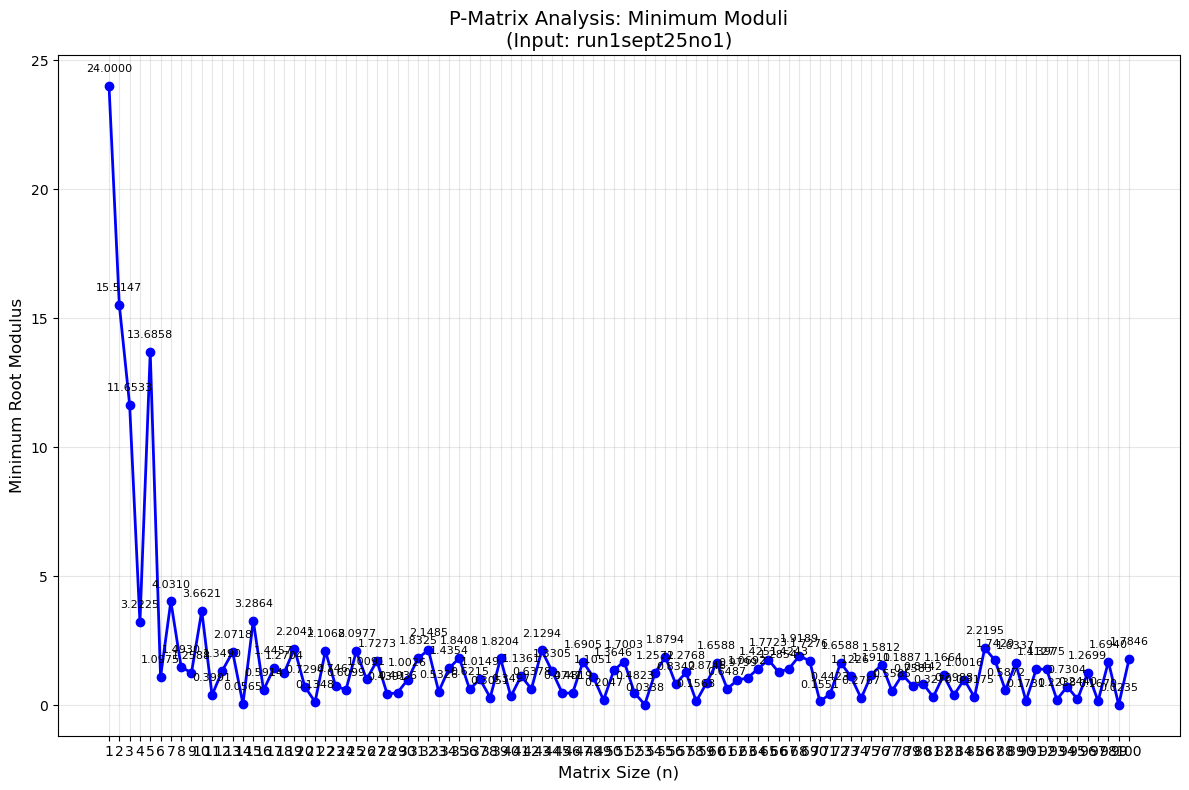


✓ ANALYSIS COMPLETE!
✓ Processed 100 matrices successfully
✓ Results saved to: /Users/barrybrent/data/run1sept25no1_pmatrix_20250908_154037
✓ All computations used exact rational arithmetic

✓ SUCCESS: Analysis completed with 100 matrices
✓ Output directory: /Users/barrybrent/data/run1sept25no1_pmatrix_20250908_154037


In [9]:
# P-matrix analysis, corrected construction per PNG and user's explicit indexing convention
import matplotlib.pyplot as plt
from sage.all import *
import os
import pickle
from datetime import datetime

VALUES_FILE = '/Users/barrybrent/data/run1sept25no1.txt'
MAX_MATRICES = 100
OUTPUT_DIR = '/Users/barrybrent/data/'

def load_values_from_file(filename):
    """Load j_list: j_list[1]=p_1, j_list[n]=p_n."""
    j_list = []
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        # If data is list of tuples: (i, val), extract val
        for entry in data:
            if isinstance(entry, (tuple, list)) and len(entry) == 2:
                j_list.append(QQ(entry[1]))
            else:
                j_list.append(QQ(entry))
        print(f"✓ Loaded {len(j_list)} values from pickled file")
        return j_list
    except Exception as e:
        print(f"Could not load as pickle: {e}")
    try:
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith('#'):
                    parts = [s for s in line.replace(',', ' ').split()]
                    for part in parts:
                        part = part.strip()
                        if part:
                            try:
                                j_list.append(QQ(part))
                            except Exception as ex:
                                print(f"Skipping value {part}: {ex}")
        print(f"✓ Loaded {len(j_list)} values from text file")
        return j_list
    except Exception as e:
        print(f"Error loading file: {e}")
        return []

def construct_p_matrix(n, j_list):
    """Construct matrix in form shown in PNG:
       - First column p_i = j_list[i] (i from 1 to n)
       - Diagonal p_1 = j_list[1]
       - Strictly lower triangle: p_{i-j+1} = j_list[i-j+1] if i>j
       - First superdiagonal: -j if j = i+1
       - Zeros elsewhere
       NOTE: Python indices: i,j both run from 0 to n-1, p_i from j_list[1] (not j_list[0])
    """
    if len(j_list) <= n:
        raise ValueError(f"Need at least n+1 j_list values; got {len(j_list)}")
    M = matrix(QQ, n, n)
    for i in range(n):
        for j in range(n):
            if j == 0:
                M[i, j] = j_list[i+1]         # First column: p_i (i+1)
            elif i == j:
                M[i, j] = j_list[1]           # Main diagonal: p_1
            elif j < i:
                M[i, j] = j_list[i-j+1]       # Lower diagonal: p_{i-j+1}
            elif j == i + 1:
                M[i, j] = - (j)               # Superdiagonal: -j
            else:
                M[i, j] = 0                   # Upper triangle and beyond superdiagonal is zero
    return M

# --- The rest of the code remains unchanged: characteristic poly, roots, output, plotting ---

def check_available_optimizations():
    print("Checking available optimization methods...")
    test_matrix = matrix(ZZ, 3, 3, [1, 2, 3, 4, 5, 6, 7, 8, 9])
    try:
        poly = test_matrix.characteristic_polynomial(algorithm='generic')
        print("✓ Integer matrices with 'generic' algorithm - this will provide speedup")
    except Exception as e:
        print(f"✗ Integer 'generic' algorithm failed: {e}")
    try:
        test_rational = matrix(QQ, 3, 3, [1, 1/2, 1/3, 1/4, 1/5, 1/6, 1/7, 1/8, 1/9])
        H, P = test_rational.hessenberg_form()
        print("✓ Hessenberg form transformation available")
    except Exception as e:
        print(f"✗ Hessenberg form failed: {e}")
    print("\nPerformance expectations without LinBox:")
    print("  Matrices 1-5:   Fast (seconds)")
    print("  Matrices 6-10:  Moderate (tens of seconds)")
    print("  Matrices 11-15: Slow (minutes)")
    print("  Matrices 16+:   Very slow (many minutes to hours)")
    print("Recommendation: Start with MAX_MATRICES = 15")
    return True

def compute_characteristic_polynomial_exact(matrix):
    import time
    start_time = time.time()
    try:
        n = matrix.nrows()
        print(f"    Computing characteristic polynomial for {n}x{n} matrix...")
        if n <= 3:
            char_poly = matrix.characteristic_polynomial()
            elapsed = time.time() - start_time
            print(f"    ✓ Standard method: {elapsed:.2f}s")
            return char_poly
        try:
            denom = lcm([matrix[i,j].denominator() for i in range(n) for j in range(n)])
            int_matrix = (matrix * denom).change_ring(ZZ)
            char_poly_scaled = int_matrix.characteristic_polynomial(algorithm='generic')
            R = PolynomialRing(QQ, 'x')
            x = R.gen()
            coeffs = char_poly_scaled.coefficients(sparse=False)
            char_poly = sum(QQ(coeffs[i]) / (denom**(n-i)) * x**i for i in range(len(coeffs)))
            elapsed = time.time() - start_time
            print(f"    ✓ Exact integer optimization: {elapsed:.2f}s")
            return char_poly
        except Exception as int_error:
            print(f"    Integer optimization failed: {int_error}")
        if n > 8:
            try:
                print(f"    Trying Hessenberg transformation...")
                H, P = matrix.hessenberg_form()
                char_poly = H.characteristic_polynomial()
                elapsed = time.time() - start_time
                print(f"    ✓ Hessenberg method: {elapsed:.2f}s")
                return char_poly
            except Exception as hess_error:
                print(f"    Hessenberg failed: {hess_error}")
        print(f"    Using standard exact method...")
        char_poly = matrix.characteristic_polynomial()
        elapsed = time.time() - start_time
        print(f"    ✓ Standard method completed: {elapsed:.2f}s")
        return char_poly
    except Exception as e:
        elapsed = time.time() - start_time
        print(f"    ❌ All methods failed after {elapsed:.2f}s: {e}")
        return None

def find_minimum_modulus_root_precise(polynomial, precision=100):
    try:
        print(f"    Finding minimum modulus root with {precision}-digit precision...")
        CC_prec = ComplexField(precision)
        roots = polynomial.roots(ring=CC_prec, multiplicities=False)
        if not roots:
            return None, None, None
        root_moduli = [(root, abs(root)) for root in roots]
        min_root, min_modulus = min(root_moduli, key=lambda x: x[1])
        CC_storage = ComplexField(precision + 50)
        high_roots = polynomial.roots(ring=CC_storage, multiplicities=False)
        high_moduli = [(root, abs(root)) for root in high_roots]
        storage_root, storage_modulus = min(high_moduli, key=lambda x: x[1])
        print(f"    ✓ Found minimum modulus: {float(storage_modulus):.8f}")
        return min_root, min_modulus, storage_root
    except Exception as e:
        print(f"    Error finding roots: {e}")
        return None, None, None

def setup_output_directory(base_dir, input_file):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    input_base = os.path.splitext(os.path.basename(input_file))[0]
    output_dir = os.path.join(base_dir, f"{input_base}_pmatrix_{timestamp}")
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

def save_matrix_data(output_dir, n, matrix, char_poly, min_root, min_modulus, storage_root):
    matrix_file = os.path.join(output_dir, f"matrix_{n}x{n}.txt")
    with open(matrix_file, 'w') as f:
        f.write(f"P-Matrix {n}x{n}:\n")
        for i in range(n):
            row = [str(matrix[i,j]) for j in range(n)]
            f.write("[" + ", ".join(row) + "]\n")
    poly_file = os.path.join(output_dir, f"polynomial_{n}x{n}.txt")
    with open(poly_file, 'w') as f:
        f.write(f"Characteristic Polynomial for {n}x{n} P-matrix:\n")
        f.write(f"Degree: {char_poly.degree()}\n")
        f.write(f"Polynomial (exact QQ format): {char_poly}\n")
        f.write(f"Ring: {char_poly.parent()}\n")
        coeffs = char_poly.coefficients(sparse=False)
        f.write(f"Coefficients (QQ): {[QQ(c) for c in coeffs]}\n")
    root_file = os.path.join(output_dir, f"root_data_{n}x{n}.txt")
    with open(root_file, 'w') as f:
        f.write(f"Root Data for {n}x{n} P-matrix:\n")
        f.write(f"Minimum modulus root: {min_root}\n")
        f.write(f"Minimum modulus: {min_modulus}\n")
        f.write(f"High precision root (100+ digits): {storage_root}\n")
        f.write(f"High precision modulus (100+ digits): {abs(storage_root)}\n")
    tuple_file = os.path.join(output_dir, f"tuple_{n}x{n}.txt")
    with open(tuple_file, 'w') as f:
        f.write(f"({n}, '{char_poly}', '{storage_root}', '{abs(storage_root)}', {float(abs(storage_root)):.12f})\n")

def save_consolidated_results(output_dir, all_tuples, n_values, moduli_values, input_file, values):
    summary_file = os.path.join(output_dir, "SUMMARY_human_readable.txt")
    with open(summary_file, 'w') as f:
        f.write("P-MATRIX ANALYSIS SUMMARY\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Input file: {input_file}\n")
        f.write(f"Matrix type: P-matrices\n")
        f.write(f"Matrices processed: {len(n_values)}\n")
        f.write(f"Parameter values: {values[:min(10, len(values))]}")
        if len(values) > 10:
            f.write("...")
        f.write("\n\n")
        f.write("MINIMUM MODULI SUMMARY:\n")
        f.write("-" * 40 + "\n")
        f.write("Matrix Size\tMinimum Modulus (12 decimal places)\n")
        f.write("-" * 40 + "\n")
        for n, modulus in zip(n_values, moduli_values):
            f.write(f"{n}x{n}\t\t{modulus:.12f}\n")
    tuples_file = os.path.join(output_dir, "ALL_TUPLES_raw_data.txt")
    with open(tuples_file, 'w') as f:
        for tuple_data in all_tuples:
            f.write(str(tuple_data) + "\n")
    pickle_file = os.path.join(output_dir, "results_data.pkl")
    with open(pickle_file, 'wb') as f:
        pickle.dump({
            'tuples': all_tuples,
            'n_values': n_values,
            'moduli_values': moduli_values,
            'matrix_type': 'P',
            'input_file': input_file,
            'parameter_values': values
        }, f)

def create_plot_with_error_handling(output_dir, n_values, moduli_values, input_file):
    try:
        plt.figure(figsize=(12, 8))
        plt.plot(n_values, moduli_values, 'bo-', linewidth=2, markersize=6)
        plt.xlabel('Matrix Size (n)', fontsize=12)
        plt.ylabel('Minimum Root Modulus', fontsize=12)
        file_base = os.path.splitext(os.path.basename(input_file))[0]
        plt.title(f'P-Matrix Analysis: Minimum Moduli\n(Input: {file_base})', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.xticks(n_values)
        for i, (x, y) in enumerate(zip(n_values, moduli_values)):
            plt.annotate(f'{y:.4f}', (x, y), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8)
        plt.tight_layout()
        plot_file = os.path.join(output_dir, "minimum_moduli_plot.png")
        plt.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"✓ Plot saved to: {plot_file}")
        try:
            plt.show()
        except:
            print("  (Plot display not available, but saved to file)")
    except Exception as e:
        print(f"Warning: Could not create plot: {e}")
        print("  Continuing with analysis...")

def analyze_p_matrices(values_file, max_n=None, precision=100, output_base_dir=None):
    print("P-MATRIX ANALYSIS TOOL")
    print("=" * 60)
    print(f"Input file: {values_file}")
    print(f"Precision: {precision} decimal places")
    print("Note: All computations use exact rational arithmetic")
    j_list = load_values_from_file(values_file)
    if not j_list:
        print("❌ No values loaded. Exiting.")
        return []
    # j_list[0] = placeholder; j_list[1] = p_1, ..., j_list[n] = p_n
    if max_n is None:
        max_n = len(j_list)-1
    else:
        max_n = min(max_n, len(j_list)-1)
    print(f"Available values: {len(j_list)}")
    print(f"Will create matrices up to size: {max_n}x{max_n}")
    if output_base_dir is None:
        output_base_dir = os.path.dirname(values_file)
    output_dir = setup_output_directory(output_base_dir, values_file)
    print(f"Output directory: {output_dir}")
    print("=" * 60)
    results = []
    n_values = []
    moduli_values = []
    all_tuples = []
    for n in range(1, max_n + 1):
        print(f"\nProcessing P-matrix of size {n}x{n}...")
        try:
            matrix = construct_p_matrix(n, j_list)
            print(f"P-matrix for n={n}:")
            for row in matrix.rows():
                if n<5:
                    print("  " + str(row))
            print("")
            char_poly = compute_characteristic_polynomial_exact(matrix)
            if char_poly is None:
                print(f"  ❌ Failed to compute polynomial")
                continue
            min_root, min_modulus, storage_root = find_minimum_modulus_root_precise(char_poly, precision)
            if min_root is None:
                print(f"  ❌ Failed to find roots")
                continue
            save_matrix_data(output_dir, n, matrix, char_poly, min_root, min_modulus, storage_root)
            tuple_data = (n, str(char_poly), str(storage_root), str(abs(storage_root)), float(abs(storage_root)))
            results.append((n, char_poly, min_root, min_modulus))
            all_tuples.append(tuple_data)
            n_values.append(n)
            moduli_values.append(float(abs(storage_root)))
            print(f"  ✓ Completed. Min modulus: {float(abs(storage_root)):.8f}")
        except Exception as e:
            print(f"  ❌ Error processing matrix {n}x{n}: {e}")
            continue
    save_consolidated_results(output_dir, all_tuples, n_values, moduli_values, values_file, j_list)
    if n_values and moduli_values:
        create_plot_with_error_handling(output_dir, n_values, moduli_values, values_file)
    print(f"\n" + "=" * 60)
    print("✓ ANALYSIS COMPLETE!")
    print(f"✓ Processed {len(results)} matrices successfully")
    print(f"✓ Results saved to: {output_dir}")
    print("✓ All computations used exact rational arithmetic")
    print("=" * 60)
    return results, output_dir

if __name__ == "__main__":
    print("STARTING P-MATRIX ANALYSIS")
    print("=" * 60)
    optimizations_available = check_available_optimizations()
    print(f"\nInput file: {VALUES_FILE}")
    if MAX_MATRICES is not None:
        print(f"Maximum matrices: {MAX_MATRICES}")
    else:
        print("Maximum matrices: All available")
    print(f"Output directory: {OUTPUT_DIR}")
    print("=" * 60)
    try:
        results, output_directory = analyze_p_matrices(VALUES_FILE, max_n=MAX_MATRICES, output_base_dir=OUTPUT_DIR)
        if results:
            print(f"\n✓ SUCCESS: Analysis completed with {len(results)} matrices")
            print(f"✓ Output directory: {output_directory}")
        else:
            print("\n❌ No matrices were successfully processed")
    except Exception as e:
        print(f"\n❌ Analysis failed: {e}")
        import traceback
        traceback.print_exc()

STARTING P-MATRIX ANALYSIS
Checking available optimization methods...
✓ Integer matrices with 'generic' algorithm - this will provide speedup
✗ Hessenberg form failed: too many values to unpack (expected 2)

Performance expectations without LinBox:
  Matrices 1-5:   Fast (seconds)
  Matrices 6-10:  Moderate (tens of seconds)
  Matrices 11-15: Slow (minutes)
  Matrices 16+:   Very slow (many minutes to hours)
Recommendation: Start with MAX_MATRICES = 15

Input file: /Users/barrybrent/data/run1sept25no1.txt
Maximum matrices: 100
Output directory: /Users/barrybrent/data/
P-MATRIX ANALYSIS TOOL
Input file: /Users/barrybrent/data/run1sept25no1.txt
Precision: 100 decimal places
Note: All computations use exact rational arithmetic
✓ Loaded 1001 values from pickled file
Available values: 1001
Will create matrices up to size: 100x100
Output directory: /Users/barrybrent/data/run1sept25no1_pmatrix_20250908_160607

Processing P-matrix of size 1x1...
P-matrix for n=1:
  (-24)

    Computing charact

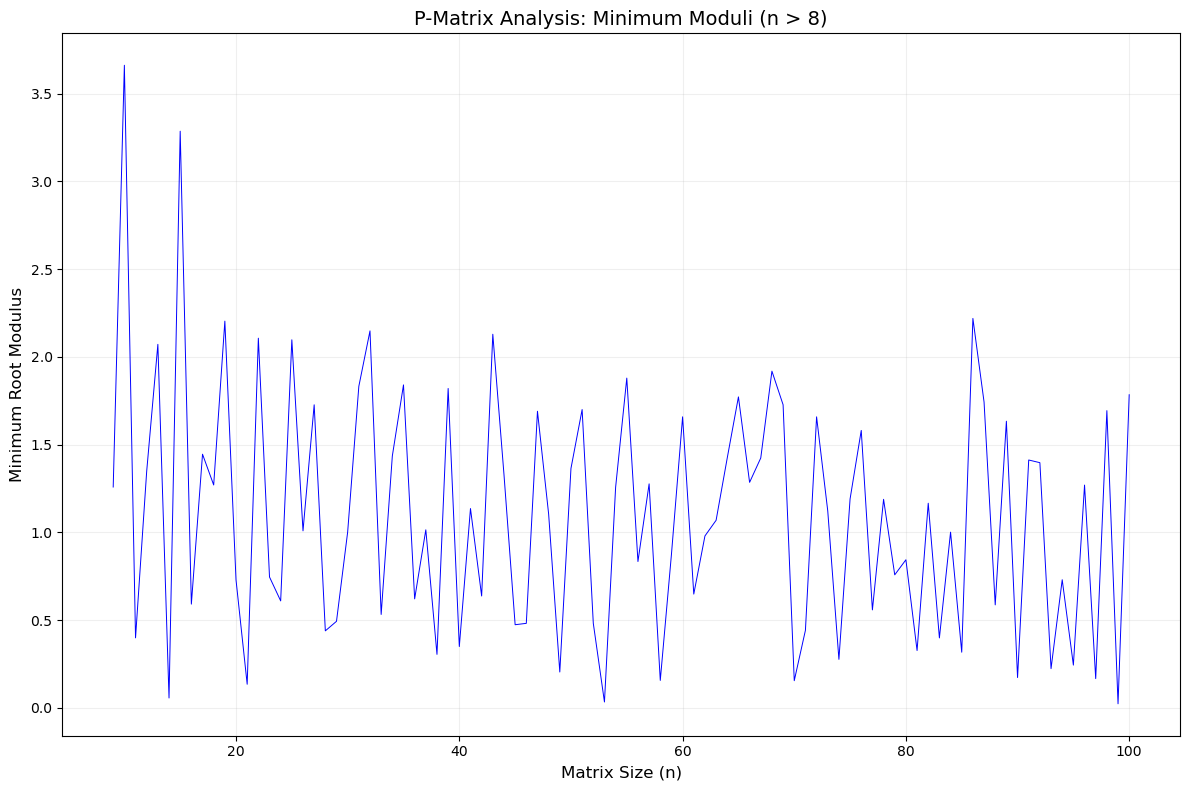


✓ ANALYSIS COMPLETE!
✓ Processed 100 matrices successfully
✓ Results saved to: /Users/barrybrent/data/run1sept25no1_pmatrix_20250908_160607
✓ All computations used exact rational arithmetic

✓ SUCCESS: Analysis completed with 100 matrices
✓ Output directory: /Users/barrybrent/data/run1sept25no1_pmatrix_20250908_160607


In [11]:
# P-matrix analysis: Structured per PNG, visual plot customized per request
import matplotlib.pyplot as plt
from sage.all import *
import os
import pickle
from datetime import datetime

# USER INPUTS
VALUES_FILE = '/Users/barrybrent/data/run1sept25no1.txt'
MAX_MATRICES = 100
OUTPUT_DIR = '/Users/barrybrent/data/'
MIN_N_PLOT = 8  # Set this value to control minimum n in the plot (e.g., 7 to plot only n > 7)

def load_values_from_file(filename):
    """Load j_list: j_list[1]=p_1, j_list[n]=p_n."""
    j_list = []
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        for entry in data:
            if isinstance(entry, (tuple, list)) and len(entry) == 2:
                j_list.append(QQ(entry[1]))
            else:
                j_list.append(QQ(entry))
        print(f"✓ Loaded {len(j_list)} values from pickled file")
        return j_list
    except Exception as e:
        print(f"Could not load as pickle: {e}")
    try:
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith('#'):
                    parts = [s for s in line.replace(',', ' ').split()]
                    for part in parts:
                        part = part.strip()
                        if part:
                            try:
                                j_list.append(QQ(part))
                            except Exception as ex:
                                print(f"Skipping value {part}: {ex}")
        print(f"✓ Loaded {len(j_list)} values from text file")
        return j_list
    except Exception as e:
        print(f"Error loading file: {e}")
        return []

def construct_p_matrix(n, j_list):
    """
    Construct matrix in PNG form:
    - First column: p_i = j_list[i]
    - Diagonal: p_1 = j_list[1]
    - Lower triangle: p_{i-j+1} = j_list[i-j+1] if i>j
    - Superdiagonal: -j if j=i+1
    - Zeros otherwise.
    """
    if len(j_list) <= n:
        raise ValueError(f"Need at least n+1 j_list values; got {len(j_list)}")
    M = matrix(QQ, n, n)
    for i in range(n):
        for j in range(n):
            if j == 0:
                M[i, j] = j_list[i+1]
            elif i == j:
                M[i, j] = j_list[1]
            elif j < i:
                M[i, j] = j_list[i-j+1]
            elif j == i + 1:
                M[i, j] = -j
            else:
                M[i, j] = 0
    return M

def check_available_optimizations():
    print("Checking available optimization methods...")
    test_matrix = matrix(ZZ, 3, 3, [1, 2, 3, 4, 5, 6, 7, 8, 9])
    try:
        poly = test_matrix.characteristic_polynomial(algorithm='generic')
        print("✓ Integer matrices with 'generic' algorithm - this will provide speedup")
    except Exception as e:
        print(f"✗ Integer 'generic' algorithm failed: {e}")
    try:
        test_rational = matrix(QQ, 3, 3, [1, 1/2, 1/3, 1/4, 1/5, 1/6, 1/7, 1/8, 1/9])
        H, P = test_rational.hessenberg_form()
        print("✓ Hessenberg form transformation available")
    except Exception as e:
        print(f"✗ Hessenberg form failed: {e}")
    print("\nPerformance expectations without LinBox:")
    print("  Matrices 1-5:   Fast (seconds)")
    print("  Matrices 6-10:  Moderate (tens of seconds)")
    print("  Matrices 11-15: Slow (minutes)")
    print("  Matrices 16+:   Very slow (many minutes to hours)")
    print("Recommendation: Start with MAX_MATRICES = 15")
    return True

def compute_characteristic_polynomial_exact(matrix):
    import time
    start_time = time.time()
    try:
        n = matrix.nrows()
        print(f"    Computing characteristic polynomial for {n}x{n} matrix...")
        if n <= 3:
            char_poly = matrix.characteristic_polynomial()
            elapsed = time.time() - start_time
            print(f"    ✓ Standard method: {elapsed:.2f}s")
            return char_poly
        try:
            denom = lcm([matrix[i,j].denominator() for i in range(n) for j in range(n)])
            int_matrix = (matrix * denom).change_ring(ZZ)
            char_poly_scaled = int_matrix.characteristic_polynomial(algorithm='generic')
            R = PolynomialRing(QQ, 'x')
            x = R.gen()
            coeffs = char_poly_scaled.coefficients(sparse=False)
            char_poly = sum(QQ(coeffs[i]) / (denom**(n-i)) * x**i for i in range(len(coeffs)))
            elapsed = time.time() - start_time
            print(f"    ✓ Exact integer optimization: {elapsed:.2f}s")
            return char_poly
        except Exception as int_error:
            print(f"    Integer optimization failed: {int_error}")
        if n > 8:
            try:
                print(f"    Trying Hessenberg transformation...")
                H, P = matrix.hessenberg_form()
                char_poly = H.characteristic_polynomial()
                elapsed = time.time() - start_time
                print(f"    ✓ Hessenberg method: {elapsed:.2f}s")
                return char_poly
            except Exception as hess_error:
                print(f"    Hessenberg failed: {hess_error}")
        print(f"    Using standard exact method...")
        char_poly = matrix.characteristic_polynomial()
        elapsed = time.time() - start_time
        print(f"    ✓ Standard method completed: {elapsed:.2f}s")
        return char_poly
    except Exception as e:
        elapsed = time.time() - start_time
        print(f"    ❌ All methods failed after {elapsed:.2f}s: {e}")
        return None

def find_minimum_modulus_root_precise(polynomial, precision=100):
    try:
        print(f"    Finding minimum modulus root with {precision}-digit precision...")
        CC_prec = ComplexField(precision)
        roots = polynomial.roots(ring=CC_prec, multiplicities=False)
        if not roots:
            return None, None, None
        root_moduli = [(root, abs(root)) for root in roots]
        min_root, min_modulus = min(root_moduli, key=lambda x: x[1])
        CC_storage = ComplexField(precision + 50)
        high_roots = polynomial.roots(ring=CC_storage, multiplicities=False)
        high_moduli = [(root, abs(root)) for root in high_roots]
        storage_root, storage_modulus = min(high_moduli, key=lambda x: x[1])
        print(f"    ✓ Found minimum modulus: {float(storage_modulus):.8f}")
        return min_root, min_modulus, storage_root
    except Exception as e:
        print(f"    Error finding roots: {e}")
        return None, None, None

def setup_output_directory(base_dir, input_file):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    input_base = os.path.splitext(os.path.basename(input_file))[0]
    output_dir = os.path.join(base_dir, f"{input_base}_pmatrix_{timestamp}")
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

def save_matrix_data(output_dir, n, matrix, char_poly, min_root, min_modulus, storage_root):
    matrix_file = os.path.join(output_dir, f"matrix_{n}x{n}.txt")
    with open(matrix_file, 'w') as f:
        f.write(f"P-Matrix {n}x{n}:\n")
        for i in range(n):
            row = [str(matrix[i,j]) for j in range(n)]
            f.write("[" + ", ".join(row) + "]\n")
    poly_file = os.path.join(output_dir, f"polynomial_{n}x{n}.txt")
    with open(poly_file, 'w') as f:
        f.write(f"Characteristic Polynomial for {n}x{n} P-matrix:\n")
        f.write(f"Degree: {char_poly.degree()}\n")
        f.write(f"Polynomial (exact QQ format): {char_poly}\n")
        f.write(f"Ring: {char_poly.parent()}\n")
        coeffs = char_poly.coefficients(sparse=False)
        f.write(f"Coefficients (QQ): {[QQ(c) for c in coeffs]}\n")
    root_file = os.path.join(output_dir, f"root_data_{n}x{n}.txt")
    with open(root_file, 'w') as f:
        f.write(f"Root Data for {n}x{n} P-matrix:\n")
        f.write(f"Minimum modulus root: {min_root}\n")
        f.write(f"Minimum modulus: {min_modulus}\n")
        f.write(f"High precision root (100+ digits): {storage_root}\n")
        f.write(f"High precision modulus (100+ digits): {abs(storage_root)}\n")
    tuple_file = os.path.join(output_dir, f"tuple_{n}x{n}.txt")
    with open(tuple_file, 'w') as f:
        f.write(f"({n}, '{char_poly}', '{storage_root}', '{abs(storage_root)}', {float(abs(storage_root)):.12f})\n")

def save_consolidated_results(output_dir, all_tuples, n_values, moduli_values, input_file, values):
    summary_file = os.path.join(output_dir, "SUMMARY_human_readable.txt")
    with open(summary_file, 'w') as f:
        f.write("P-MATRIX ANALYSIS SUMMARY\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Input file: {input_file}\n")
        f.write(f"Matrix type: P-matrices\n")
        f.write(f"Matrices processed: {len(n_values)}\n")
        f.write(f"Parameter values: {values[:min(10, len(values))]}")
        if len(values) > 10:
            f.write("...")
        f.write("\n\n")
        f.write("MINIMUM MODULI SUMMARY:\n")
        f.write("-" * 40 + "\n")
        f.write("Matrix Size\tMinimum Modulus (12 decimal places)\n")
        f.write("-" * 40 + "\n")
        for n, modulus in zip(n_values, moduli_values):
            f.write(f"{n}x{n}\t\t{modulus:.12f}\n")
    tuples_file = os.path.join(output_dir, "ALL_TUPLES_raw_data.txt")
    with open(tuples_file, 'w') as f:
        for tuple_data in all_tuples:
            f.write(str(tuple_data) + "\n")
    pickle_file = os.path.join(output_dir, "results_data.pkl")
    with open(pickle_file, 'wb') as f:
        pickle.dump({
            'tuples': all_tuples,
            'n_values': n_values,
            'moduli_values': moduli_values,
            'matrix_type': 'P',
            'input_file': input_file,
            'parameter_values': values
        }, f)

def plot_minimum_moduli(n_values, moduli_values, min_n=0):
    """
    Customized plot: thinner line, no disks, no value labels, only data with n>min_n.
    """
    # Filter data using the index control
    filtered_n = [n for n in n_values if n > min_n]
    filtered_moduli = [moduli_values[i] for i, n in enumerate(n_values) if n > min_n]
    if not filtered_n:
        print(f"No data points for n > {min_n}")
        return
    plt.figure(figsize=(12, 8))
    plt.plot(filtered_n, filtered_moduli, linestyle='-', color='blue', linewidth=0.7)  # Thin line, no markers
    plt.xlabel('Matrix Size (n)', fontsize=12)
    plt.ylabel('Minimum Root Modulus', fontsize=12)
    plt.title(f'P-Matrix Analysis: Minimum Moduli (n > {min_n})', fontsize=14)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

def analyze_p_matrices(values_file, max_n=None, precision=100, output_base_dir=None, min_n_plot=0):
    print("P-MATRIX ANALYSIS TOOL")
    print("=" * 60)
    print(f"Input file: {values_file}")
    print(f"Precision: {precision} decimal places")
    print("Note: All computations use exact rational arithmetic")
    j_list = load_values_from_file(values_file)
    if not j_list:
        print("❌ No values loaded. Exiting.")
        return []
    # j_list[0] = placeholder; j_list[1]=p_1, ..., j_list[n]=p_n
    if max_n is None:
        max_n = len(j_list)-1
    else:
        max_n = min(max_n, len(j_list)-1)
    print(f"Available values: {len(j_list)}")
    print(f"Will create matrices up to size: {max_n}x{max_n}")
    if output_base_dir is None:
        output_base_dir = os.path.dirname(values_file)
    output_dir = setup_output_directory(output_base_dir, values_file)
    print(f"Output directory: {output_dir}")
    print("=" * 60)
    results = []
    n_values = []
    moduli_values = []
    all_tuples = []
    for n in range(1, max_n + 1):
        print(f"\nProcessing P-matrix of size {n}x{n}...")
        try:
            matrix = construct_p_matrix(n, j_list)
            print(f"P-matrix for n={n}:")
            for row in matrix.rows():
                if n<5:
                    print("  " + str(row))
            print("")
            char_poly = compute_characteristic_polynomial_exact(matrix)
            if char_poly is None:
                print(f"  ❌ Failed to compute polynomial")
                continue
            min_root, min_modulus, storage_root = find_minimum_modulus_root_precise(char_poly, precision)
            if min_root is None:
                print(f"  ❌ Failed to find roots")
                continue
            save_matrix_data(output_dir, n, matrix, char_poly, min_root, min_modulus, storage_root)
            tuple_data = (n, str(char_poly), str(storage_root), str(abs(storage_root)), float(abs(storage_root)))
            results.append((n, char_poly, min_root, min_modulus))
            all_tuples.append(tuple_data)
            n_values.append(n)
            moduli_values.append(float(abs(storage_root)))
            print(f"  ✓ Completed. Min modulus: {float(abs(storage_root)):.8f}")
        except Exception as e:
            print(f"  ❌ Error processing matrix {n}x{n}: {e}")
            continue
    save_consolidated_results(output_dir, all_tuples, n_values, moduli_values, values_file, j_list)
    # Use new plot with control for min_n_plot
    if n_values and moduli_values:
        plot_minimum_moduli(n_values, moduli_values, min_n=min_n_plot)
    print(f"\n" + "=" * 60)
    print("✓ ANALYSIS COMPLETE!")
    print(f"✓ Processed {len(results)} matrices successfully")
    print(f"✓ Results saved to: {output_dir}")
    print("✓ All computations used exact rational arithmetic")
    print("=" * 60)
    return results, output_dir

if __name__ == "__main__":
    print("STARTING P-MATRIX ANALYSIS")
    print("=" * 60)
    optimizations_available = check_available_optimizations()
    print(f"\nInput file: {VALUES_FILE}")
    if MAX_MATRICES is not None:
        print(f"Maximum matrices: {MAX_MATRICES}")
    else:
        print("Maximum matrices: All available")
    print(f"Output directory: {OUTPUT_DIR}")
    print("=" * 60)
    try:
        results, output_directory = analyze_p_matrices(
            VALUES_FILE,
            max_n=MAX_MATRICES,
            output_base_dir=OUTPUT_DIR,
            min_n_plot=MIN_N_PLOT  # Set this to user-selected threshold for "n > *"
        )
        if results:
            print(f"\n✓ SUCCESS: Analysis completed with {len(results)} matrices")
            print(f"✓ Output directory: {output_directory}")
        else:
            print("\n❌ No matrices were successfully processed")
    except Exception as e:
        print(f"\n❌ Analysis failed: {e}")
        import traceback
        traceback.print_exc()


STARTING P-MATRIX ANALYSIS
Checking available optimization methods...
✓ Integer matrices with 'generic' algorithm - this will provide speedup
✗ Hessenberg form failed: too many values to unpack (expected 2)

Performance expectations without LinBox:
  Matrices 1-5:   Fast (seconds)
  Matrices 6-10:  Moderate (tens of seconds)
  Matrices 11-15: Slow (minutes)
  Matrices 16+:   Very slow (many minutes to hours)
Recommendation: Start with MAX_MATRICES = 15

Input file: /Users/barrybrent/data/run1sept25no1.txt
Maximum matrices: 300
Output directory: /Users/barrybrent/data/
P-MATRIX ANALYSIS TOOL
Input file: /Users/barrybrent/data/run1sept25no1.txt
Precision: 100 decimal places
Note: All computations use exact rational arithmetic
✓ Loaded 1001 values from pickled file
Available values: 1001
Will create matrices up to size: 300x300
Output directory: /Users/barrybrent/data/run1sept25no1_pmatrix_20250908_170023

Processing P-matrix of size 1x1...
P-matrix for n=1:
  (-24)

    Computing charact

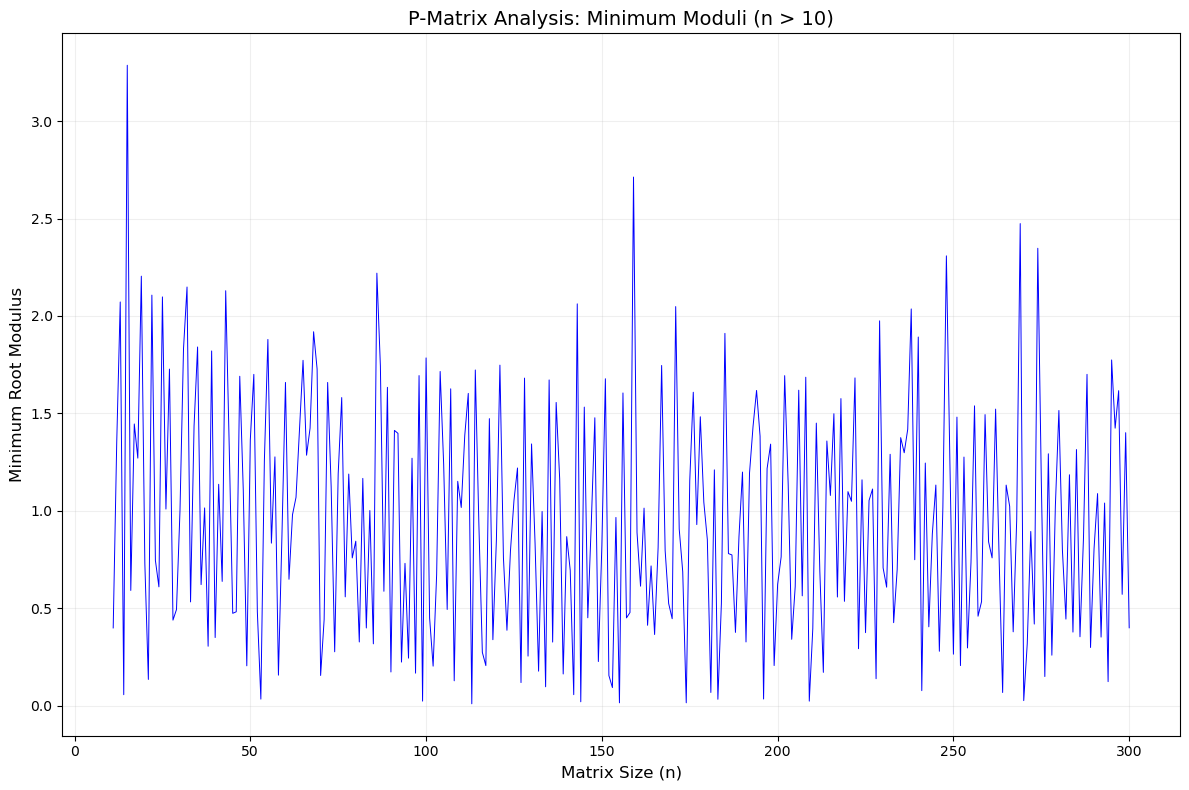


✓ ANALYSIS COMPLETE!
✓ Processed 300 matrices successfully
✓ Results saved to: /Users/barrybrent/data/run1sept25no1_pmatrix_20250908_170023
✓ All computations used exact rational arithmetic

✓ SUCCESS: Analysis completed with 300 matrices
✓ Output directory: /Users/barrybrent/data/run1sept25no1_pmatrix_20250908_170023


In [1]:
# P-matrix analysis: Structured per PNG, visual plot customized per request, with print control
import matplotlib.pyplot as plt
from sage.all import *
import os
import pickle
from datetime import datetime

# ================================
# USER INPUTS: Controls
# ================================
VALUES_FILE = '/Users/barrybrent/data/run1sept25no1.txt'
MAX_MATRICES = 300
OUTPUT_DIR = '/Users/barrybrent/data/'
MIN_N_PLOT = 10        # Only plot minimum modulus data for n > MIN_N_PLOT
PRINT_LIMIT_N = 10     # Only print matrix+charpoly for n < PRINT_LIMIT_N

def load_values_from_file(filename):
    """Load j_list: j_list[1]=p_1, j_list[n]=p_n."""
    j_list = []
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        for entry in data:
            if isinstance(entry, (tuple, list)) and len(entry) == 2:
                j_list.append(QQ(entry[1]))
            else:
                j_list.append(QQ(entry))
        print(f"✓ Loaded {len(j_list)} values from pickled file")
        return j_list
    except Exception as e:
        print(f"Could not load as pickle: {e}")
    try:
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith('#'):
                    parts = [s for s in line.replace(',', ' ').split()]
                    for part in parts:
                        part = part.strip()
                        if part:
                            try:
                                j_list.append(QQ(part))
                            except Exception as ex:
                                print(f"Skipping value {part}: {ex}")
        print(f"✓ Loaded {len(j_list)} values from text file")
        return j_list
    except Exception as e:
        print(f"Error loading file: {e}")
        return []

def construct_p_matrix(n, j_list):
    """
    Construct matrix in PNG form:
    - First column: p_i = j_list[i]
    - Diagonal: p_1 = j_list[1]
    - Lower triangle: p_{i-j+1} = j_list[i-j+1] if i>j
    - Superdiagonal: -j if j=i+1
    - Zeros otherwise.
    """
    if len(j_list) <= n:
        raise ValueError(f"Need at least n+1 j_list values; got {len(j_list)}")
    M = matrix(QQ, n, n)
    for i in range(n):
        for j in range(n):
            if j == 0:
                M[i, j] = j_list[i+1]
            elif i == j:
                M[i, j] = j_list[1]
            elif j < i:
                M[i, j] = j_list[i-j+1]
            elif j == i + 1:
                M[i, j] = -j
            else:
                M[i, j] = 0
    return M

def check_available_optimizations():
    print("Checking available optimization methods...")
    test_matrix = matrix(ZZ, 3, 3, [1, 2, 3, 4, 5, 6, 7, 8, 9])
    try:
        poly = test_matrix.characteristic_polynomial(algorithm='generic')
        print("✓ Integer matrices with 'generic' algorithm - this will provide speedup")
    except Exception as e:
        print(f"✗ Integer 'generic' algorithm failed: {e}")
    try:
        test_rational = matrix(QQ, 3, 3, [1, 1/2, 1/3, 1/4, 1/5, 1/6, 1/7, 1/8, 1/9])
        H, P = test_rational.hessenberg_form()
        print("✓ Hessenberg form transformation available")
    except Exception as e:
        print(f"✗ Hessenberg form failed: {e}")
    print("\nPerformance expectations without LinBox:")
    print("  Matrices 1-5:   Fast (seconds)")
    print("  Matrices 6-10:  Moderate (tens of seconds)")
    print("  Matrices 11-15: Slow (minutes)")
    print("  Matrices 16+:   Very slow (many minutes to hours)")
    print("Recommendation: Start with MAX_MATRICES = 15")
    return True

def compute_characteristic_polynomial_exact(matrix):
    import time
    start_time = time.time()
    try:
        n = matrix.nrows()
        print(f"    Computing characteristic polynomial for {n}x{n} matrix...")
        if n <= 3:
            char_poly = matrix.characteristic_polynomial()
            elapsed = time.time() - start_time
            print(f"    ✓ Standard method: {elapsed:.2f}s")
            return char_poly
        try:
            denom = lcm([matrix[i,j].denominator() for i in range(n) for j in range(n)])
            int_matrix = (matrix * denom).change_ring(ZZ)
            char_poly_scaled = int_matrix.characteristic_polynomial(algorithm='generic')
            R = PolynomialRing(QQ, 'x')
            x = R.gen()
            coeffs = char_poly_scaled.coefficients(sparse=False)
            char_poly = sum(QQ(coeffs[i]) / (denom**(n-i)) * x**i for i in range(len(coeffs)))
            elapsed = time.time() - start_time
            print(f"    ✓ Exact integer optimization: {elapsed:.2f}s")
            return char_poly
        except Exception as int_error:
            print(f"    Integer optimization failed: {int_error}")
        if n > 8:
            try:
                print(f"    Trying Hessenberg transformation...")
                H, P = matrix.hessenberg_form()
                char_poly = H.characteristic_polynomial()
                elapsed = time.time() - start_time
                print(f"    ✓ Hessenberg method: {elapsed:.2f}s")
                return char_poly
            except Exception as hess_error:
                print(f"    Hessenberg failed: {hess_error}")
        print(f"    Using standard exact method...")
        char_poly = matrix.characteristic_polynomial()
        elapsed = time.time() - start_time
        print(f"    ✓ Standard method completed: {elapsed:.2f}s")
        return char_poly
    except Exception as e:
        elapsed = time.time() - start_time
        print(f"    ❌ All methods failed after {elapsed:.2f}s: {e}")
        return None

def find_minimum_modulus_root_precise(polynomial, precision=100):
    try:
        print(f"    Finding minimum modulus root with {precision}-digit precision...")
        CC_prec = ComplexField(precision)
        roots = polynomial.roots(ring=CC_prec, multiplicities=False)
        if not roots:
            return None, None, None
        root_moduli = [(root, abs(root)) for root in roots]
        min_root, min_modulus = min(root_moduli, key=lambda x: x[1])
        CC_storage = ComplexField(precision + 50)
        high_roots = polynomial.roots(ring=CC_storage, multiplicities=False)
        high_moduli = [(root, abs(root)) for root in high_roots]
        storage_root, storage_modulus = min(high_moduli, key=lambda x: x[1])
        print(f"    ✓ Found minimum modulus: {float(storage_modulus):.8f}")
        return min_root, min_modulus, storage_root
    except Exception as e:
        print(f"    Error finding roots: {e}")
        return None, None, None

def setup_output_directory(base_dir, input_file):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    input_base = os.path.splitext(os.path.basename(input_file))[0]
    output_dir = os.path.join(base_dir, f"{input_base}_pmatrix_{timestamp}")
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

def save_matrix_data(output_dir, n, matrix, char_poly, min_root, min_modulus, storage_root):
    matrix_file = os.path.join(output_dir, f"matrix_{n}x{n}.txt")
    with open(matrix_file, 'w') as f:
        f.write(f"P-Matrix {n}x{n}:\n")
        for i in range(n):
            row = [str(matrix[i,j]) for j in range(n)]
            f.write("[" + ", ".join(row) + "]\n")
    poly_file = os.path.join(output_dir, f"polynomial_{n}x{n}.txt")
    with open(poly_file, 'w') as f:
        f.write(f"Characteristic Polynomial for {n}x{n} P-matrix:\n")
        f.write(f"Degree: {char_poly.degree()}\n")
        f.write(f"Polynomial (exact QQ format): {char_poly}\n")
        f.write(f"Ring: {char_poly.parent()}\n")
        coeffs = char_poly.coefficients(sparse=False)
        f.write(f"Coefficients (QQ): {[QQ(c) for c in coeffs]}\n")
    root_file = os.path.join(output_dir, f"root_data_{n}x{n}.txt")
    with open(root_file, 'w') as f:
        f.write(f"Root Data for {n}x{n} P-matrix:\n")
        f.write(f"Minimum modulus root: {min_root}\n")
        f.write(f"Minimum modulus: {min_modulus}\n")
        f.write(f"High precision root (100+ digits): {storage_root}\n")
        f.write(f"High precision modulus (100+ digits): {abs(storage_root)}\n")
    tuple_file = os.path.join(output_dir, f"tuple_{n}x{n}.txt")
    with open(tuple_file, 'w') as f:
        f.write(f"({n}, '{char_poly}', '{storage_root}', '{abs(storage_root)}', {float(abs(storage_root)):.12f})\n")

def save_consolidated_results(output_dir, all_tuples, n_values, moduli_values, input_file, values):
    summary_file = os.path.join(output_dir, "SUMMARY_human_readable.txt")
    with open(summary_file, 'w') as f:
        f.write("P-MATRIX ANALYSIS SUMMARY\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"Input file: {input_file}\n")
        f.write(f"Matrix type: P-matrices\n")
        f.write(f"Matrices processed: {len(n_values)}\n")
        f.write(f"Parameter values: {values[:min(10, len(values))]}")
        if len(values) > 10:
            f.write("...")
        f.write("\n\n")
        f.write("MINIMUM MODULI SUMMARY:\n")
        f.write("-" * 40 + "\n")
        f.write("Matrix Size\tMinimum Modulus (12 decimal places)\n")
        f.write("-" * 40 + "\n")
        for n, modulus in zip(n_values, moduli_values):
            f.write(f"{n}x{n}\t\t{modulus:.12f}\n")
    tuples_file = os.path.join(output_dir, "ALL_TUPLES_raw_data.txt")
    with open(tuples_file, 'w') as f:
        for tuple_data in all_tuples:
            f.write(str(tuple_data) + "\n")
    pickle_file = os.path.join(output_dir, "results_data.pkl")
    with open(pickle_file, 'wb') as f:
        pickle.dump({
            'tuples': all_tuples,
            'n_values': n_values,
            'moduli_values': moduli_values,
            'matrix_type': 'P',
            'input_file': input_file,
            'parameter_values': values
        }, f)

def plot_minimum_moduli(n_values, moduli_values, min_n=0):
    """
    Customized plot: thinner line, no disks, no value labels, only data with n>min_n.
    """
    filtered_n = [n for n in n_values if n > min_n]
    filtered_moduli = [moduli_values[i] for i, n in enumerate(n_values) if n > min_n]
    if not filtered_n:
        print(f"No data points for n > {min_n}")
        return
    plt.figure(figsize=(12, 8))
    plt.plot(filtered_n, filtered_moduli, linestyle='-', color='blue', linewidth=0.7)  # Thin line, no markers
    plt.xlabel('Matrix Size (n)', fontsize=12)
    plt.ylabel('Minimum Root Modulus', fontsize=12)
    plt.title(f'P-Matrix Analysis: Minimum Moduli (n > {min_n})', fontsize=14)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

def analyze_p_matrices(values_file, max_n=None, precision=100, output_base_dir=None,
                       min_n_plot=0, print_limit_n=0):
    print("P-MATRIX ANALYSIS TOOL")
    print("=" * 60)
    print(f"Input file: {values_file}")
    print(f"Precision: {precision} decimal places")
    print("Note: All computations use exact rational arithmetic")
    j_list = load_values_from_file(values_file)
    if not j_list:
        print("❌ No values loaded. Exiting.")
        return []
    if max_n is None:
        max_n = len(j_list)-1
    else:
        max_n = min(max_n, len(j_list)-1)
    print(f"Available values: {len(j_list)}")
    print(f"Will create matrices up to size: {max_n}x{max_n}")
    if output_base_dir is None:
        output_base_dir = os.path.dirname(values_file)
    output_dir = setup_output_directory(output_base_dir, values_file)
    print(f"Output directory: {output_dir}")
    print("=" * 60)
    results = []
    n_values = []
    moduli_values = []
    all_tuples = []
    for n in range(1, max_n + 1):
        do_print = (n < print_limit_n)  # Check print control
        if do_print:
            print(f"\nProcessing P-matrix of size {n}x{n}...")
        try:
            matrix = construct_p_matrix(n, j_list)
            if do_print:
                print(f"P-matrix for n={n}:")
                for row in matrix.rows():
                    print("  " + str(row))
                print("")
            char_poly = compute_characteristic_polynomial_exact(matrix)
            if char_poly is None:
                if do_print:
                    print(f"  ❌ Failed to compute polynomial")
                continue
            if do_print:
                print(f"Characteristic polynomial for n={n}:")
                print(f"  {char_poly}\n")
            min_root, min_modulus, storage_root = find_minimum_modulus_root_precise(char_poly, precision)
            if min_root is None:
                if do_print:
                    print(f"  ❌ Failed to find roots")
                continue
            save_matrix_data(output_dir, n, matrix, char_poly, min_root, min_modulus, storage_root)
            tuple_data = (n, str(char_poly), str(storage_root), str(abs(storage_root)), float(abs(storage_root)))
            results.append((n, char_poly, min_root, min_modulus))
            all_tuples.append(tuple_data)
            n_values.append(n)
            moduli_values.append(float(abs(storage_root)))
            if do_print:
                print(f"  ✓ Completed. Min modulus: {float(abs(storage_root)):.8f}")
        except Exception as e:
            if do_print:
                print(f"  ❌ Error processing matrix {n}x{n}: {e}")
            continue
    save_consolidated_results(output_dir, all_tuples, n_values, moduli_values, values_file, j_list)
    if n_values and moduli_values:
        plot_minimum_moduli(n_values, moduli_values, min_n=min_n_plot)
    print(f"\n" + "=" * 60)
    print("✓ ANALYSIS COMPLETE!")
    print(f"✓ Processed {len(results)} matrices successfully")
    print(f"✓ Results saved to: {output_dir}")
    print("✓ All computations used exact rational arithmetic")
    print("=" * 60)
    return results, output_dir

if __name__ == "__main__":
    print("STARTING P-MATRIX ANALYSIS")
    print("=" * 60)
    optimizations_available = check_available_optimizations()
    print(f"\nInput file: {VALUES_FILE}")
    if MAX_MATRICES is not None:
        print(f"Maximum matrices: {MAX_MATRICES}")
    else:
        print("Maximum matrices: All available")
    print(f"Output directory: {OUTPUT_DIR}")
    print("=" * 60)
    try:
        results, output_directory = analyze_p_matrices(
            VALUES_FILE,
            max_n=MAX_MATRICES,
            output_base_dir=OUTPUT_DIR,
            min_n_plot=MIN_N_PLOT,         # Plot control: only n > MIN_N_PLOT
            print_limit_n=PRINT_LIMIT_N    # Print control: only n < PRINT_LIMIT_N
        )
        if results:
            print(f"\n✓ SUCCESS: Analysis completed with {len(results)} matrices")
            print(f"✓ Output directory: {output_directory}")
        else:
            print("\n❌ No matrices were successfully processed")
    except Exception as e:
        print(f"\n❌ Analysis failed: {e}")
        import traceback
        traceback.print_exc()
